In [1]:
### IMPORTING REQUIRED PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning modules
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
#### LOADING DATA ####

train = pd.read_csv("train.csv", na_values='-1')
test = pd.read_csv("test.csv", na_values='-1')
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [3]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.340435696874
Number of records with target=0 after undersampling: 195246


In [4]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)  

In [5]:
## Filling the missing data NAN with median of the column
train_data_nato_median = pd.DataFrame()
for column in train.columns:
    train_data_nato_median[column] = train[column].fillna(train[column].median())

train = train_data_nato_median.copy()

## Filling the missing data NAN with mean of the column
test_data_nato_median = pd.DataFrame()
for column in test.columns:
    test_data_nato_median[column] = test[column].fillna(test[column].median())
    
test = test_data_nato_median.copy()

In [6]:
## Identifying Categorical data
column_names = train.columns
categorical_column = column_names[column_names.str[10] == 'c']

## Changing categorical columns to category data type
def int_to_categorical(data):
    """ 
    changing columns to catgorical data type
    """
    for column in categorical_column:
        data[column] =  data[column].astype('category')

In [7]:
## Creating list of train and test data and converting columns of interest to categorical type
datas = [train,test]

for data in datas:
    int_to_categorical(data)

print(test.dtypes)

id                  int64
ps_ind_01           int64
ps_ind_02_cat    category
ps_ind_03           int64
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat    category
ps_car_02_cat    category
ps_car_03_cat    category
ps_car_04_cat    category
ps_car_05_cat    category
ps_car_06_cat    category
ps_car_07_cat    category
ps_car_08_cat    category
ps_car_09_cat    category
ps_car_10_cat    category
ps_car_11_cat    category
ps_car_11         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15         float64
dtype: objec

In [8]:
### FUNCTION TO CREATE DUMMIES COLUMNS FOR CATEGORICAL VARIABLES
def creating_dummies(data):
    """creating dummies columns categorical varibles
    """
    for column in categorical_column:
        dummies = pd.get_dummies(data[column],prefix=column)
        data = pd.concat([data,dummies],axis =1)
        ## dropping the original columns ##
        data.drop([column],axis=1,inplace= True)

In [9]:
### CREATING DUMMIES FOR CATEGORICAL VARIABLES  
for column in categorical_column:
        dummies = pd.get_dummies(train[column],prefix=column)
        train = pd.concat([train,dummies],axis =1)
        train.drop([column],axis=1,inplace= True)


for column in categorical_column:
        dummies = pd.get_dummies(test[column],prefix=column)
        test = pd.concat([test,dummies],axis =1)
        test.drop([column],axis=1,inplace= True)

print(train.shape)
print(test.shape)

(216940, 200)
(892816, 199)


In [10]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [11]:
# Stratified K Fold
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [12]:
# Set parameters for XGBoost 
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [13]:
#Define X and y
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1).values

In [14]:
#X = X[:,[142,135,150,14,138,143,139,141,136,61,151,11,179,146,140,86,175,147, 152,145,180,148,177,133,59,60,183,14,51,34,67,137,16,161,88,85,159,33,178,184,65,13,12,63,18,156,83,87]]
#test = test[:,[142,135,150,14,138,143,139,141,136,61,151,11,179,146,140,86,175,147, 152,145,180,148,177,133,59,60,183,14,51,34,67,137,16,161,88,85,159,33,178,184,65,13,12,63,18,156,83,87]]

In [15]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [16]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-error:0.099971	valid-error:0.100094	train-gini:0.189847	valid-gini:0.150323
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.099999	valid-error:0.100002	train-gini:0.337376	valid-gini:0.266573
[200]	train-error:0.099982	valid-error:0.100002	train-gini:0.375523	valid-gini:0.273421
[300]	train-error:0.099896	valid-error:0.100002	train-gini:0.402403	valid-gini:0.27612
[400]	train-error:0.09985	valid-error:0.100025	train-gini:0.42281	valid-gini:0.275951
Stopping. Best iteration:
[339]	train-error:0.099861	valid-error:0.100025	train-gini:0.410622	valid-gini:0.27649

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-error:0.099999	valid-error:0.100005	train-gini:0.170796	valid-gini:0.142337
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.099999	val

In [17]:
sub.to_csv('StratifiedKFold5.csv', index=False)

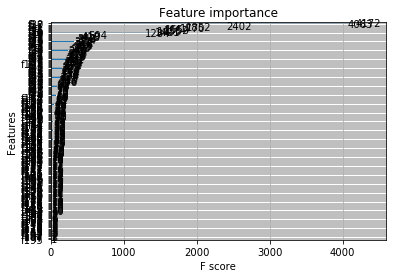

In [18]:
from xgboost import plot_importance
plot_importance(mdl)
plt.show()